# Data Analysis: S&P Stocks - 2013/2018

## Business Understanding
For this project, we use the data provided in the Kaggle "S&P 500 stock data" (https://www.kaggle.com/camnugent/sandp500), and contains the daily quotation of 505 assets, between the period of February / 2013 and February / 2018.

Our intention in conducting this project is to evaluate the behavior of the price of these assets, and see if it is more advantageous to buy and remain with the asset or, at random, select one of these assets and buy at the beginning of the week and sell at the end of the same week. .

The S&P 500 index in the same period of the data varied from 1,514.68 points in 2013 to 2713.83 in 2018, an appreciation of 79%.

Questions to be answered:

- What is the average valuation of assets in the period?
- Which assets were the most valued?
- Which assets have devalued the most?
- Is it more advantageous to buy and stay with the asset or to carry out the random purchase and stay with the assets for just 1 week?
- In a random way, did we manage to beat the S&P 500 index?

<center>Import all necessary libraries</center>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import mannwhitneyu
from random import sample

%matplotlib inline

C:\Users\danie\server\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Getting Data

<center>Open file and transform it in Pandas Dataframe. After this, check number os rows and columns.</center>

In [4]:
frame = pd.read_csv('all_stocks_5yr.csv', parse_dates=['date'])
frame.rename(columns={'Name':'ticker'}, inplace=True)

print('Dataframe size is: ', frame.shape)


Dataframe size is:  (619040, 7)


## Clean Data

<center>Check if any rows in dataframe is null value.</center>

In [5]:
frame.isnull().mean()

date      0.000000
open      0.000018
high      0.000013
low       0.000013
close     0.000000
volume    0.000000
ticker    0.000000
dtype: float64

<center>Exclude any row with null values</center>

In [7]:
frame.dropna(how='any', inplace=True)

## Prepare and gather data

<center>We aggregate the data in order to have, for each ticker, the smallest and the largest date it has on the dataframe. With this, we created a new dataframe, and increased it with the value it has on the first date it appeared, and the value it had on the last date it appeared.</center>

<center>We created a new column with the name "evolution", and in it we store the percentage that the price of the paper varied in the period.</center>

In [8]:
frame_ticker = frame[['ticker', 'date']].groupby('ticker').agg(['min', 'max']).reset_index()
frame_ticker.columns = ['_'.join(col) for col in frame_ticker.columns.values]
frame_ticker.rename(columns={'ticker_':'ticker'}, inplace=True)
frame_ticker = pd.merge(
    frame_ticker,
    frame[['ticker', 'date', 'open']].rename(columns={'date':'date_min'}),
    how='inner',
    left_on=['ticker', 'date_min'],
    right_on=['ticker', 'date_min']
)
frame_ticker = pd.merge(
    frame_ticker,
    frame[['ticker', 'date', 'close']].rename(columns={'date':'date_max'}),
    how='inner',
    left_on=['ticker', 'date_max'],
    right_on=['ticker', 'date_max']
)

frame_ticker['evolution'] = (frame_ticker['close']/frame_ticker['open'])-1

frame_ticker

,ticker,date_min,date_max,open,close,evolution
0,A,2013-02-08,2018-02-07,45.0700,68.06,0.510095
1,AAL,2013-02-08,2018-02-07,15.0700,51.40,2.410750
2,AAP,2013-02-08,2018-02-07,78.3400,109.93,0.403242
3,AAPL,2013-02-08,2018-02-07,67.7142,159.54,1.356079
4,ABBV,2013-02-08,2018-02-07,36.3700,113.62,2.124003
...,...,...,...,...,...,...
500,XYL,2013-02-08,2018-02-07,27.0100,71.79,1.657904
501,YUM,2013-02-08,2018-02-07,63.7000,80.13,0.257928
502,ZBH,2013-02-08,2018-02-07,75.0200,120.78,0.609971
503,ZION,2013-02-08,2018-02-07,24.0300,54.02,1.248023


<center>We will create a new column on the initial dataframe. This column will contain the year data and the week of the year. After creating this field, we will build a new dataframe, and it will contain the ticker, the new year and week field, the start and end date of the week, the opening and closing value of the week. And finally, what was the percentage variation between the opening and closing prices of the week.</center>

In [9]:
#create column with year and week year number
frame['year_week'] = frame['date'].apply(lambda x: str(x.isocalendar()[0])+'_'+str(x.isocalendar()[1]))

#create a copy of dataframe to be used and get week initial and final day
frame_week = frame[['ticker', 'year_week', 'date']].groupby(['ticker', 'year_week']).agg(['min', 'max'])
frame_week.reset_index(inplace=True)
frame_week.columns = ['_'.join(col) for col in frame_week.columns.values]
frame_week.rename(columns={'ticker_':'ticker', 'year_week_':'year_week'}, inplace=True)

#for ticker and unique year_week get open week price and close week price
frame_week = pd.merge(
    frame_week,
    frame[['ticker', 'date', 'open']].rename(columns={'date':'date_min'}),
    how='inner',
    left_on=['ticker', 'date_min'],
    right_on=['ticker', 'date_min']
)

frame_week = pd.merge(
    frame_week,
    frame[['ticker', 'date', 'close']].rename(columns={'date':'date_max'}),
    how='inner',
    left_on=['ticker', 'date_max'],
    right_on=['ticker', 'date_max']
)

#order dataframe using date_min column
frame_week.sort_values(by='date_min', inplace=True)

# percentual variation between open and close week
frame_week['variation'] = (frame_week['close']/frame_week['open'])-1

#number of days in week
frame_week['days_week'] = frame_week['date_max']-frame_week['date_min']

frame_week

,ticker,year_week,date_min,date_max,open,close,variation,days_week
2401,ADI,2013_6,2013-02-08,2013-02-08,44.72,45.70,0.021914,0 days
119982,VLO,2013_6,2013-02-08,2013-02-08,45.58,46.13,0.012067,0 days
32314,CVX,2013_6,2013-02-08,2013-02-08,114.93,115.64,0.006178,0 days
128352,ZION,2013_6,2013-02-08,2013-02-08,24.03,24.14,0.004578,0 days
7379,ALL,2013_6,2013-02-08,2013-02-08,45.05,45.14,0.001998,0 days
...,...,...,...,...,...,...,...,...
70465,L,2018_6,2018-02-05,2018-02-07,50.42,47.86,-0.050774,2 days
14640,AXP,2018_6,2018-02-05,2018-02-07,95.83,93.61,-0.023166,2 days
70203,KSU,2018_6,2018-02-05,2018-02-07,109.73,107.10,-0.023968,2 days
1833,ABT,2018_6,2018-02-05,2018-02-07,61.60,58.67,-0.047565,2 days


<center>The first week, which makes up the data, consists of just 1 day. As our intention is to evaluate the performance of the tickers in a full week, we decided to exclude this week. The exclusion resulted in 481 lines. The specific week was the week 2013_6.</center>

In [10]:
print('Will delete %s rows' % (frame_week[frame_week.days_week=='0 days'].shape[0]))
frame_week.drop(frame_week[frame_week.days_week=='0 days'].index, inplace=True)

Will delete 481 rows


## Analyse Data

<center>Number of companies in dataframe</center>

In [253]:
print('Number of companies in dataframe: ', len(frame.ticker.unique()))

Number of companies in dataframe:  505


<center>Get minimum and maximum date from dataframe</center>

In [254]:
print('Minimum date: ', frame.date.min())
print('Maximum date: ', frame.date.max())

Minimum date:  2013-02-08 00:00:00
Maximum date:  2018-02-07 00:00:00


<center>During the period, 72 companies depreciated. While the other 433 have increased their values.</center>

In [258]:
print('Companies with positive returns: ',frame_ticker[frame_ticker.evolution > 0].shape[0])
print('Companies with negative returns: ',frame_ticker[frame_ticker.evolution < 0].shape[0])
print('% of positive returns: ', round(frame_ticker[frame_ticker.evolution > 0].shape[0]/frame_ticker.shape[0], 2))

Companies with positive returns:  433
Companies with negative returns:  72
% of positive returns:  0.86


<center>We created a function to randomly select the companies that we pass through a list. It will also be possible to select the number of companies desired</center>

In [264]:
def get_sample(population, number_of_samples):
    """
    IN:
        population: list like object with examples to be selected
        number_of_samples: number of samples to be selected in population
    OUT:
        list of selected samples
    """ 
    selected_samples = sample(population, number_of_samples)
    return selected_samples

The simulation will select, for each week, the purchase and closing of operations at the end of it, randomly selecting the tickers. We will simulate with 10 tickers per week.
We will iterate the simulation by 100x. Aggregating the results obtained in each iteration in a list, which will be transformed into a dataframe.

In [265]:
number_of_samples = 10
historical_result = list()
n_iterations = 100

for iteration in range(n_iterations):
    iteration_start = datetime.now()
    for year_week in frame_week.year_week.unique():
        available_tickers = list(frame_week[frame_week.year_week == year_week].ticker.unique())
        selected_tickers = get_sample(available_tickers, number_of_samples)
        result = frame_week[
            (frame_week.year_week==year_week) & (frame_week.ticker.isin(selected_tickers))
        ].variation.sum()
        historical_result.append([
            iteration, year_week, result, selected_tickers
            
        ])
    print('Iteration %s finished in %s' % (iteration, (datetime.now()-iteration_start)))

Iteration 0 finished in 0:00:05.037547
Iteration 1 finished in 0:00:04.992649
Iteration 2 finished in 0:00:05.072389
Iteration 3 finished in 0:00:04.971756
Iteration 4 finished in 0:00:05.169064
Iteration 5 finished in 0:00:05.140251
Iteration 6 finished in 0:00:05.514924
Iteration 7 finished in 0:00:05.173144
Iteration 8 finished in 0:00:05.183143
Iteration 9 finished in 0:00:05.288856
Iteration 10 finished in 0:00:05.140255
Iteration 11 finished in 0:00:05.145801
Iteration 12 finished in 0:00:05.314550
Iteration 13 finished in 0:00:05.150595
Iteration 14 finished in 0:00:05.093684
Iteration 15 finished in 0:00:05.077609
Iteration 16 finished in 0:00:05.173019
Iteration 17 finished in 0:00:05.155488
Iteration 18 finished in 0:00:05.053485
Iteration 19 finished in 0:00:04.984794
Iteration 20 finished in 0:00:05.125295
Iteration 21 finished in 0:00:05.157324
Iteration 22 finished in 0:00:05.163146
Iteration 23 finished in 0:00:05.187129
Iteration 24 finished in 0:00:05.159215
Iteration 

With the results of the simulation, we set up a dataframe to analyze the data. And we can already see that the average increase in the portfolio would have been 625%, with a deviation of 136%. In the simulations carried out, none of the iterations resulted in a decrease in the initial value.

In [266]:
df = pd.DataFrame(historical_result, columns=['iteration', 'year_week', 'result', 'tickers'])
df[['iteration', 'result']].groupby('iteration').agg('sum').describe()

,result
count,100.000000
mean,6.254520
std,1.360133
min,2.578677
25%,5.365903
50%,6.179728
75%,7.201540
max,9.315008


Plotting the result, week by week, for each of the simulations carried out, we can observe that there are periods that all decrease in value, but end up recovering and ending with a positive result.

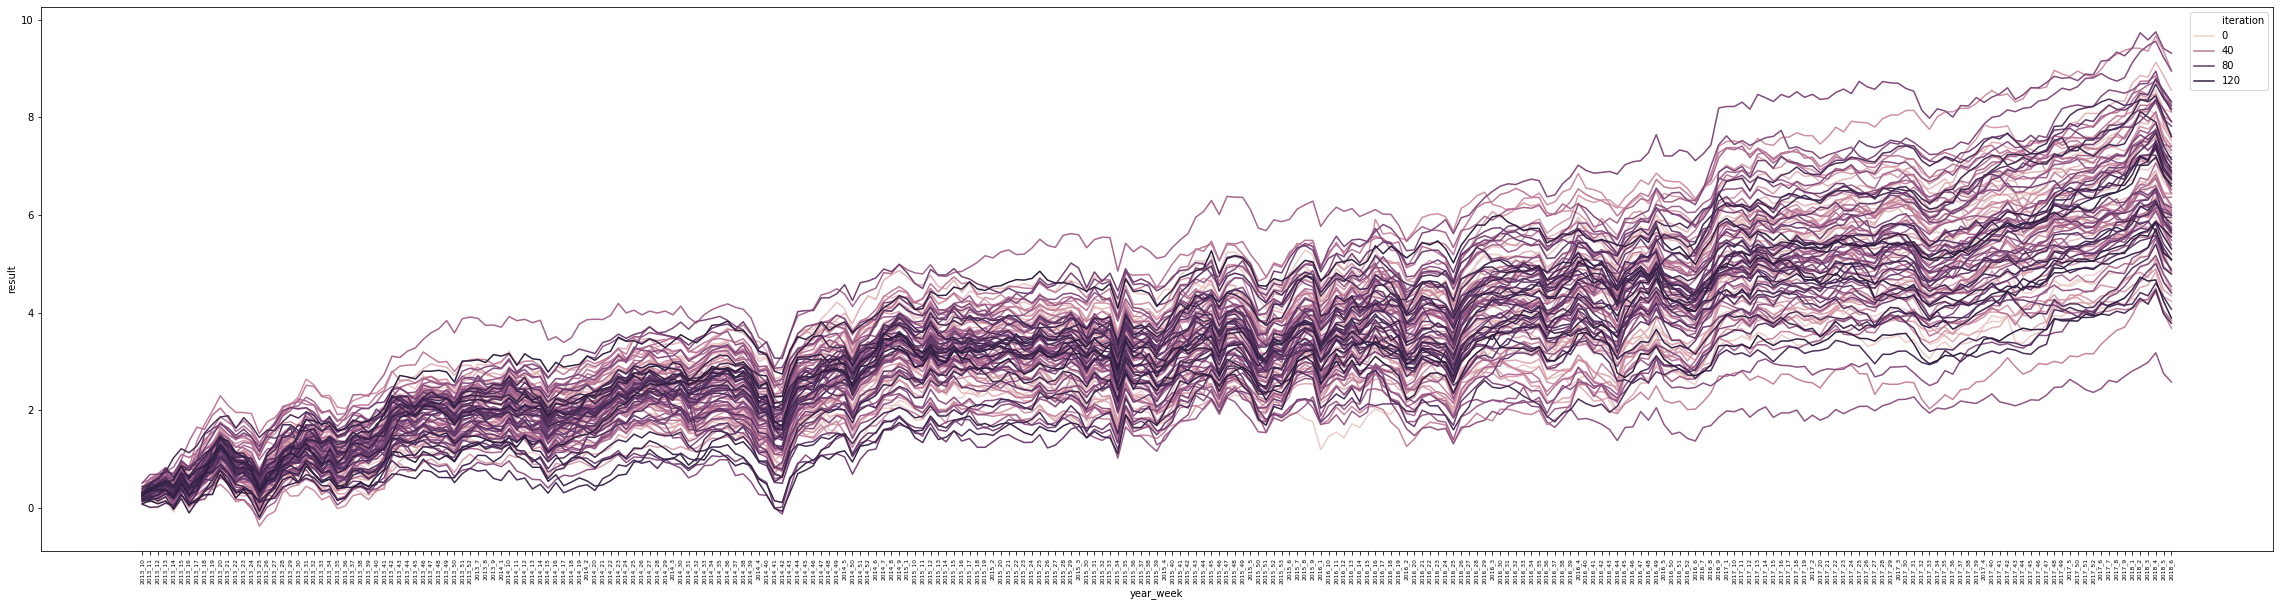

In [267]:
plt.figure(figsize=(40,10))
plt.xticks(rotation=90, fontsize=6)
g = sns.lineplot(data=df[['iteration', 'year_week', 'result']].groupby(by=['iteration', 'year_week']).sum().groupby(level=[0]).cumsum().reset_index(),
             x='year_week',
             y='result',
             hue='iteration'
            )


# Answering questions

### What is the average valuation of assets in the period?

The average valuation of companies in the period was 93%, but with a standard deviation of 133%.
The worst performing paper depreciated 85.6%, while at the other end, the paper that most appreciated, increased its value by 17.4x.
In the graph we can see the distribution of the companies' performances.

count    505.000000
mean       0.938086
std        1.332087
min       -0.856647
25%        0.219037
50%        0.699087
75%        1.249239
max       17.496362
Name: evolution, dtype: float64


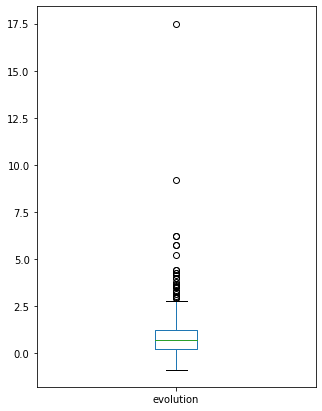

In [273]:
frame_ticker.boxplot(column='evolution', grid=False, figsize=(5,7))
print(frame_ticker.evolution.describe())

### Which assets were the most valued?

In [274]:
frame_ticker.sort_values(by='evolution', ascending=False).head()

,ticker,date_min,date_max,open,close,evolution
346,NVDA,2013-02-08,2018-02-07,12.3700,228.80,17.496362
334,NFLX,2013-02-08,2018-02-07,25.9635,264.56,9.189689
26,ALGN,2013-02-08,2018-02-07,32.4000,234.33,6.232407
153,EA,2013-02-08,2018-02-07,17.0500,123.05,6.217009
427,STZ,2013-02-08,2018-02-07,31.6200,214.15,5.772612


### Which assets have devalued the most?

In [275]:
frame_ticker.sort_values(by='evolution', ascending=True).head()

,ticker,date_min,date_max,open,close,evolution
95,CHK,2013-02-08,2018-02-07,20.1600,2.89,-0.856647
403,RRC,2013-02-08,2018-02-07,71.6200,13.12,-0.816811
453,UA,2016-04-08,2018-02-07,41.6100,12.15,-0.708003
138,DISCA,2013-02-08,2018-02-07,70.8199,23.12,-0.673538
139,DISCK,2013-02-08,2018-02-07,64.5300,21.95,-0.659848


### Is it more advantageous to buy and stay with the asset or to carry out the random purchase and stay with the assets for just 1 week?

Considering the average earnings, of the 505 companies in the period, against the average earnings obtained by the iterations in the simulation, we can statistically (p <0.05) prove that the averages are different. The average obtained by the simulations is higher.

In [315]:
mannwhitneyu(
    frame_ticker.evolution.tolist(),
    df[['iteration', 'result']].groupby('iteration').agg('sum')['result'].tolist()
)

MannwhitneyuResult(statistic=481.0, pvalue=1.4872618353738326e-54)

### In a random way, did we manage to beat the S&P 500 index?

Yes, if we consider that the growth of the index was 79% and in the worst scenario of simulation the growth was 257%, then we can say that the random one was better.

In [310]:
print('Worst simulation: ', min(df[['iteration', 'result']].groupby('iteration').agg('sum')['result'].tolist()))

Worst simulation:  2.578676970571922


## Conclusions

With the study, many other questions arose that we need to answer before stating with absolute certainty which method is best, whether it is random or buy and hold. One of the questions we must ask is: are only 5 years of data able to satisfy the research? In my opinion, no. We need to increase our time series so that we can mitigate the effect of external factors, such as stock market crashes, economic and social crises.

But, even with the limitations, we can verify that buying and selling the assets at random, in the period of time analyzed, would bring a higher return when buying and holding. A note: if the investor chose in 2013 the 5 assets that performed best, he would have a portfolio that performed better than the random one.

Reminding everyone that this is not a recommendation to buy and sell assets, nor a strategy. Just a study to provoke how much the random can command the stock exchanges.